### notes: we havent added the 0.25 degree buffer to the country borders yet for the analysis. Maybe do it later :)
do you get the difference between 3035 and 4326 and what is for what?

eligible area for single zones??? for some reason that does not work

In [14]:
GRB_LICENSE_FILE= 'C:\\Users\\leoni\\Desktop\\gurobi.lic'

In [15]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.crs as ccrs
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
from rasterio.plot import show
from shapely.ops import unary_union
import rasterio
import atlite
from urllib.request import urlretrieve
import xarray as xr
import pypsa

In [16]:
file = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
shapes = gpd.read_file(file).set_index('name')

In [17]:
spain = shapes.query("index == 'ES'").to_crs(3035).geometry
spain.explore()

In [23]:
regions = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-ESP.gpkg"
regions = gpd.read_file(regions).to_crs(3035)

In [24]:
regions = regions.drop(12)

In [25]:
regions =regions.drop(13)

In [26]:
regions = regions.drop(6) #this is some part of Africa that belongs to spain, i think we shouldn't consider it

### create 5 zones for the analysis:

In [27]:
zone1 = regions.drop(range(1,6))
zone1 = zone1.drop(range(7,12))
zone1 = zone1.drop(range(14,17))
zone1 = unary_union(zone1.geometry)

#comunidad valencia, castilla la mancha, extremadura, madrid
zone2 = regions.drop([0,1,2,4,5,8,11,14,15,16,17])
zone2 = unary_union(zone2.geometry)

#cataluna und aragon
zone3 = regions.drop([0,2,3,4,7,8,9,10,11,14,15,16,17])
zone3 = unary_union(zone3.geometry)

#8,14,15,4,16,2
zone4 = regions.drop([0,1,3,5,7,9,10,11,17])
zone4 = unary_union(zone4.geometry)

zone5 = regions.drop([0,1,2,3,4,5,7,8,9,10,14,15,16,17])
zone5 = unary_union(zone5.geometry)

geometries = [zone1,zone2,zone3,zone4,zone5]
names = ['zone_1','zone_2','zone_3','zone_4','zone_5',]

In [28]:
zones = gpd.GeoDataFrame(names, geometry = geometries, crs = 3035)
zones['center'] = zones.geometry.centroid

In [221]:
type(zones.geometry.centroid)

geopandas.geoseries.GeoSeries

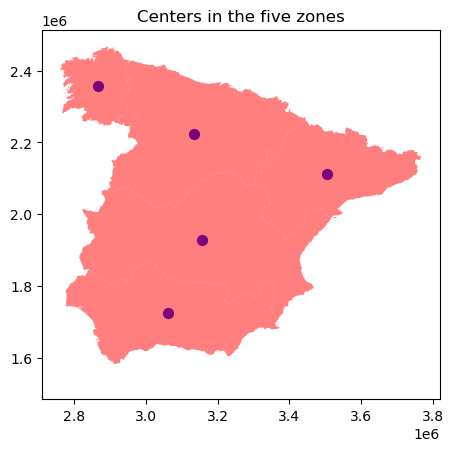

In [29]:
fig, ax = plt.subplots()

# Plot the points
zones.center.plot(ax=ax, color='blue', markersize=50)
point_color = (1, 0, 0, 0.5)
zones.geometry.plot(ax=ax, color=point_color )
ax.set_title("Centers in the five zones")

# Display the plot
plt.show()

## First, perform a land eligibility analysis
### onshore wind:
- 10km distance to airports
- 300m distance to major roads
- no natural protection areas
- maximum elevation of 2000m
- 1000m distance to built up areas
- only on suitable land cover classes

### land cover clases: 

0:  no valid input data
20: Shrubs
30: herbaceous vegetation
40: Cultivated and managed vegetation/agriculture (cropland)
60: bare/sparse vegetation
90: Herbaceous wetland
50: Urban / built up

In [30]:
# downloading files in local filesystem
file_roads = "ne_10m_roads.gpkg"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files={file_roads}"
urlretrieve(url,file_roads)

file_airport = "ne_10m_airports.gpkg"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files={file_airport}"
urlretrieve(url,file_airport)

file_classes = "PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files={file_classes}"
urlretrieve(url,file_classes)

file_elevation = "GEBCO_2014_2D-ES.nc"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files={file_elevation}"
urlretrieve(url,file_elevation)

file_protected = "WDPA_Oct2022_Public_shp-ESP.tif"
url = f"https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files={file_protected}"
urlretrieve(url,file_protected)

file_marine = "eez_v11.gpkg"
weather_data = 'era5-2020-ES.nc'
zones_area = zones.geometry

In [31]:
def plot_area(masked, transform, shape):
    fig, ax = plt.subplots(figsize=(5,5))
    ax = show(masked, transform=transform, cmap='Greens', vmin=0, ax=ax)
    shape.plot(ax=ax, edgecolor='k', color='None', linewidth=1)

In [32]:
#just for me because the download doesnt work
file_roads = 'ne_10m_roads.gpkg'
file_airport = 'ne_10m_airports.gpkg'
file_clases = 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif'
#file_elevation = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-ES.nc'
file_elevation = 'GEBCO_2014_2D-ES.nc'
file_protected = 'WDPA_Oct2022_Public_shp-ESP.tif'
weather_data = 'era5-2020-ES.nc'
zones_area = zones.geometry
file_marine = "eez_v11.gpkg"
weather_data = 'era5-2020-ES.nc'

In [224]:
excluder_onwind = ExclusionContainer(crs=3035, res = 500) #delete 'res' when its working
#roads
excluder_onwind.add_geometry(file_roads, buffer = 300)

#airports
excluder_onwind.add_geometry(file_airport, buffer = 10000)

#exclude natural protected areas
excluder_onwind.add_raster(file_protected,crs=3035)

#exclude area higher than 2000m
excluder_onwind.add_raster(file_elevation, codes = lambda x: x<2000, crs=4326, invert=True)

#1000m distance to built up areas
excluder_onwind.add_raster(file_classes, codes=[50], buffer=1000, crs=4326) #built up area [50]: CGLOPS1_PUM_LC100m-V3_I3.4.pdf 

#suitable land cover classes 
eligible = [20,30,40,60] #checked with similarities with CORINE LAND CLASSES 
excluder_onwind.add_raster(file_classes, codes=eligible,  crs=4326, invert=True)

masked, transform = shape_availability(zones_area, excluder_onwind)
plot_area(masked, transform, zones_area)

KeyboardInterrupt: 

In [348]:
eligible_cells = masked.sum()
cell_area = excluder_onwind.res**2
area_onwind= int(cell_area) * int(eligible_cells)*(1/1e6) #km² (not sure if thats true)
area_onwind

581425.0

## !!! integrate different areas of zones

### Offshore Wind
- within EEZ
- up to water depth of 50m
- no natural protection areas
- 10km minimum distance to shore

In [35]:
# Load EEZ
EEZ = gpd.read_file(file_marine)
# Extract EEZ of Spain and change CRS
EEZ_Spa = EEZ[EEZ['GEONAME'] == 'Spanish Exclusive Economic Zone']
EEZ_Spa = EEZ_Spa.to_crs(3035)

<Axes: >

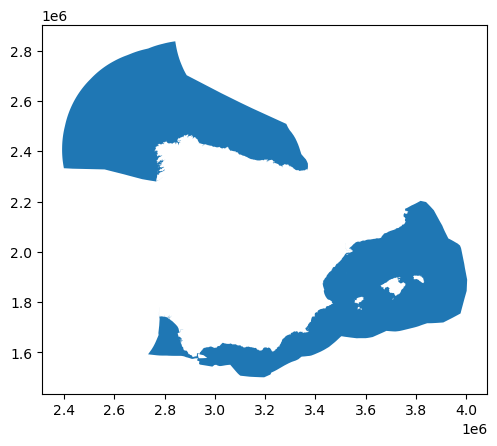

In [36]:
EEZ_Spa.geometry.plot()

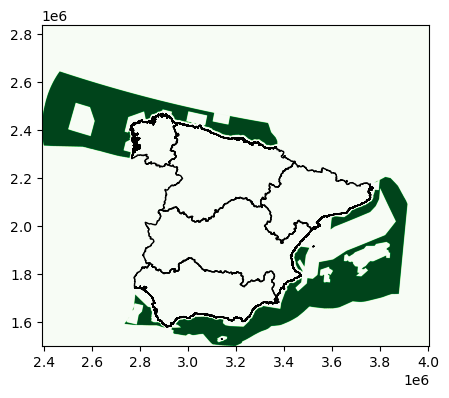

In [37]:
# Land eligibility for offshore wind
# define excluder to get eligible area
excluder_offwind = ExclusionContainer(crs=3035, res=300)

# Exclude elevation < -50 m
fn = file_elevation
excluder_offwind.add_raster(fn, codes= lambda x: x>-50, crs=4326)

# Exclude protected areas
fn = file_protected
excluder_offwind.add_raster(fn, crs=3035)

#Exclude 10km  distance to shore
excluder_offwind.add_geometry(zones_area, buffer=10000)

masked, transform = shape_availability(EEZ_Spa.geometry, excluder_offwind)
plot_area(masked, transform, zones_area)


In [222]:
from shapely.geometry import Point
EEZ_center = Point(38.703798, 1.505650)

In [39]:
eligible_cells = masked.sum()
cell_area = excluder_offwind.res**2
area_offwind = int(cell_area) * int(eligible_cells)*(1/1e6) #km² (not sure if thats true)
area_offwind

276548.04

### Solar (rooftop & utility)
- only on suitable land cover classes
- no natural protection areas

#### land cover clases:

- 0: no valid input data 
- 20: Shrubs 
- 30: herbaceous vegetation 
- 40: Cultivated and managed vegetation/agriculture (cropland) 
- 60: bare/sparse vegetation 
- 90: Herbaceous wetland 
- 50: Urban / built up

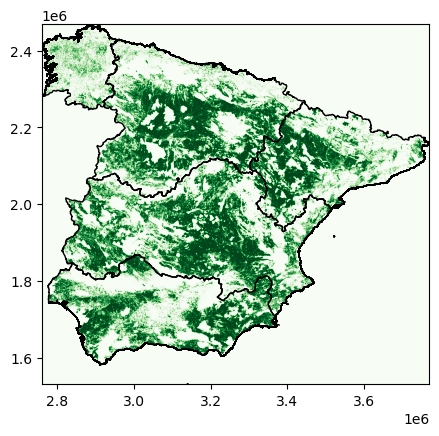

In [40]:
# Solar land eligibility

# Define excluder to get eligible area
excludersolar = ExclusionContainer(crs=3035, res=300)

# Only include suitable land classes
fn = file_classes
codes_solar=[0,20,30,40,60,90]
excludersolar.add_raster(fn, codes=codes_solar, crs=4326, invert=True)

# Exclude protected areas
fn = file_protected
excludersolar.add_raster(fn, crs=3035)

# Compute eligible area for solar
masked, transform = shape_availability(zones_area, excludersolar)

# Plot eligible area
plot_area(masked, transform, zones_area)

#### calculate the available land for solar

In [41]:
zones.to_crs(3035).geometry[0]

In [106]:
masked, transform = shape_availability(zones_area, excludersolar)
eligible_cells = masked.sum()
cell_area = excludersolar.res**2
area_solar = int(cell_area) * int(eligible_cells)*(1/1e6) #km² (not sure if thats true)
area_solar

209313.0

## Second, using atlite download historical weather data from the ERA5 dataset into an atlite.

### Cutout as shown in the lecture for a year of your choice and the geographical bounds of your selected country (add a buffer of 0.25 degrees). 

In [43]:
cutout = atlite.Cutout('era5-2020-ES_EEZ.nc')
cutout.data

<xarray.Dataset>
Dimensions:           (x: 83, y: 64, time: 8784)
Coordinates:
  * x                 (x) float64 -13.25 -13.0 -12.75 -12.5 ... 6.75 7.0 7.25
  * y                 (y) float64 32.0 32.25 32.5 32.75 ... 47.25 47.5 47.75
  * time              (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(83,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(64,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(64, 83), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 64, 83), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['temperature', 'runoff', 'wind', 'height', 'influx']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-07-14 11:45:53 GMT by grib_to_netcdf-2.25.1: /op...

<Axes: >

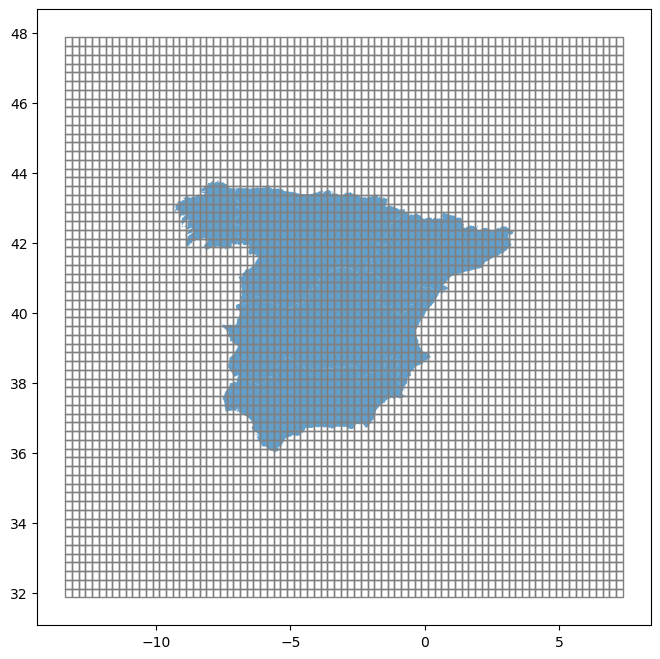

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
zones_area.to_crs(4326).plot(ax=ax,alpha = 0.7,)
cutout.grid.plot(ax=ax, edgecolor='grey', color='None')

### Then, together with the availability matrix and the corresponding atlite conversion functions, calculate the wind and solar capacity factor time series per modelled region.

### 1. For onshore wind, use a "Vestas_V112_3MW" as reference turbine.
- hubheight 84m
- assume z_0 for eligible area same as Open flat grass = 0.03

<GeoAxes: xlabel='x', ylabel='y'>

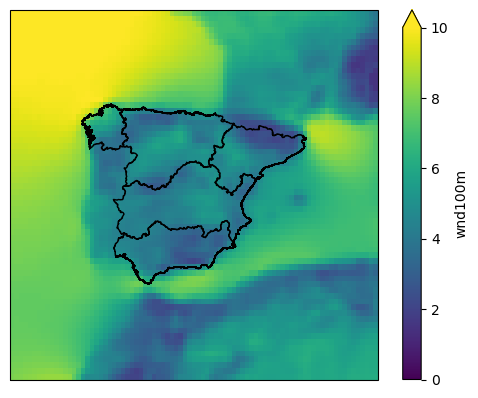

In [45]:
# Showing available wind in Onshore at 100m
wnd100m = cutout.data.wnd100m.mean(dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd100m.plot(ax=ax, vmin=0, vmax=10)
zones_area.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

In [47]:
#Calculating the Windspeed at 90m using surface roughness z
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m
wnd84m = wnd100m * np.log(84 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

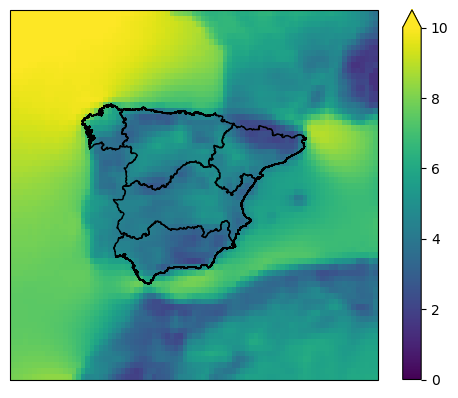

In [48]:
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd84m.mean(dim='time').plot(ax=ax, vmin=0, vmax=10)
zones_area.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

#### Availability function: Onwind

In [49]:
A_onwind = cutout.availabilitymatrix(zones_area, excluder_onwind) #somehow this is just 0

Compute availability matrix: 100%|███████████████████████████████████████████████| 5/5 [03:16<00:00, 39.39s/ gridcells]


#### Capacity Matrix: Onwind

In [278]:
#calculate the capacity factors using the wind speed in the availability matrix: 
cap_per_sqkm = 3
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))

capacity_matrix_onwind= A_onwind.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [284]:
A_onwind.values
#A_onwind.stack(spatial=['y', 'x']).values
#area.values
#capacity_matrix_onwind.values

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

#### Capacity factor: Onwind

In [303]:
on_wind = cutout.wind(
    atlite.windturbines.Vestas_V112_3MW,
    matrix=capacity_matrix_onwind, 
    index = zones_area.index,
    per_unit = True
)
on_wind = on_wind.to_pandas()
on_wind.head()

dim_0,0,1,2,3,4
time,,,,,
2020-01-01 00:00:00,0.025350,0.000649,0.000754,0.000209,0.001862
2020-01-01 01:00:00,0.025969,0.000386,0.000874,0.000083,0.001073
2020-01-01 02:00:00,0.025719,0.000195,0.001469,0.000068,0.001126
2020-01-01 03:00:00,0.026445,0.000319,0.001118,0.000104,0.001269
2020-01-01 04:00:00,0.024962,0.000680,0.001107,0.000303,0.000745


### 2. For offshore wind, use a "NREL_ReferenceTurbine_5MW_offshore" as reference turbine.

- hubhight 90m
- assume z_0 for Open sea = 0.0002

<GeoAxes: xlabel='x', ylabel='y'>

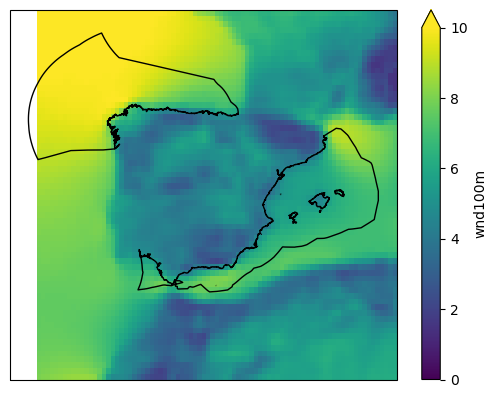

In [53]:
# Showing available wind in EEZ of Spain at 100m
wnd100m = cutout.data.wnd100m.mean(dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd100m.plot(ax=ax, vmin=0, vmax=10)
EEZ_Spa.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

In [54]:
#Calculating the Windspeed at 90m using surface roughness z
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m
wnd90m = wnd100m * np.log(90 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

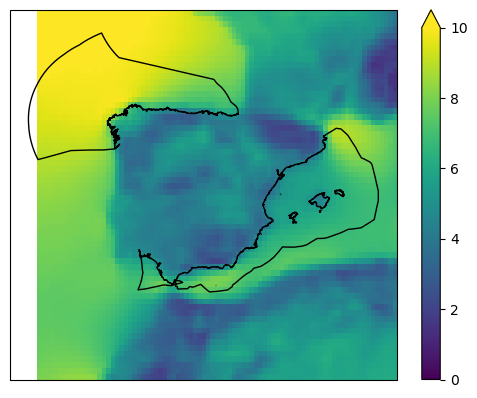

In [55]:
ax = plt.axes(projection=ccrs.PlateCarree())# das ist noch die falsche projection glaube ich 
wnd90m.mean(dim='time').plot(ax=ax, vmin=0, vmax=10)
EEZ_Spa.to_crs(4326).plot(ax=ax, edgecolor='k', color='none')

#### Availability function: Offwind

In [56]:
A_offwind = cutout.availabilitymatrix(EEZ_Spa, excluder_offwind)

Compute availability matrix: 100%|███████████████████████████████████████████████| 1/1 [00:19<00:00, 19.88s/ gridcells]


#### Capacity matrix: Offwind

In [57]:
#calculate the capacity factors using the wind speed in the availability matrix: 
cap_per_sqkm = 3
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))

capacity_matrix_offwind= A_offwind.stack(spatial=['y', 'x']) * area * cap_per_sqkm

#### Capacity factor: Offwind

In [61]:
#calculate the capacity factor time series for offshore:
off_wind = cutout.wind(
    matrix=capacity_matrix_offwind, 
    turbine="NREL_ReferenceTurbine_5MW_offshore", 
    index = EEZ_Spa.index,
    per_unit = True
)

In [62]:
off_wind = off_wind.to_pandas()
off_wind.head()

dim_0,276
time,
2020-01-01 00:00:00,0.045668
2020-01-01 01:00:00,0.042422
2020-01-01 02:00:00,0.039375
2020-01-01 03:00:00,0.036543
2020-01-01 04:00:00,0.033728


### 3. For solar, use a "CdTe" solar panel with optimal latitude orientation.

#### Availability function: Solar

In [63]:
A_onsolar = cutout.availabilitymatrix(zones_area, excludersolar)

Compute availability matrix: 100%|███████████████████████████████████████████████| 5/5 [00:27<00:00,  5.48s/ gridcells]


#### Capacity matrix: Solar

In [64]:
cap_per_sqkm = 3
# Comppute area of provinces
area = cutout.grid.set_index(['y', 'x']).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=('spatial'))
# Compute onwind capacity matrix
capacity_matrix_solar = A_onsolar.stack(spatial=['y', 'x']) * area * cap_per_sqkm

In [65]:
capacity_matrix_solar

<xarray.DataArray (dim_0: 5, spatial: 5312)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4
  * spatial  (spatial) object MultiIndex
  * y        (spatial) float64 32.0 32.0 32.0 32.0 ... 47.75 47.75 47.75 47.75
  * x        (spatial) float64 -13.25 -13.0 -12.75 -12.5 ... 6.5 6.75 7.0 7.25

#### Capacity factor: Solar

In [331]:
# Define PV profile
pv = cutout.pv(
    panel=atlite.solarpanels.CdTe,
    matrix=capacity_matrix_solar,
    orientation='latitude_optimal',
    index=zones_area.index,
    per_unit=True,
)

[########################################] | 100% Completed | 11.03 s


In [332]:
pv = pv.to_pandas()

## Build a PyPSA model that minimises total annual system costs

In [122]:
#create new network:

net = pypsa.Network()

TypeError: 'float' object cannot be interpreted as an integer

In [180]:
hpy = (365*24)//3 #hours per year in a 3 hourly resolution
net.set_snapshots(range(hpy)) #to add time varying data

## adding the buses aka centers of the zones

#### spatial resolution with regions from above. The model should include at least5 buses representing the regions. For the coordinates, take the representative points of the region shapes

In [179]:
#add busses to network --> here the centers of the zones
#do we have to add v_nom as the load or something? 
#are the coordinates correct? like crs..?
for i in range(len(zones)):
    net.add("Bus", "zone{}".format(i), x=zones.center.x[i], y=zones.center.y[i]) #v_nom = nominal voltage of each bus
#net.add("Bus","EEZ",)

In [181]:
net.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
zone0,20.0,,3.062303e+06,1.724021e+06,AC,None,1.0,0.0,inf,PQ,
zone1,20.0,,3.157637e+06,1.928169e+06,AC,None,1.0,0.0,inf,PQ,
zone2,20.0,,3.504944e+06,2.112058e+06,AC,None,1.0,0.0,inf,PQ,
zone3,20.0,,3.133547e+06,2.224783e+06,AC,None,1.0,0.0,inf,PQ,
zone4,20.0,,2.866014e+06,2.357678e+06,AC,None,1.0,0.0,inf,PQ,


#### the temporal resolution downsampled the time series to a 3-hourly resolution

In [337]:
pv_3h = pv.resample('3H').sum()
on_wind_3h = on_wind.resample('3H').sum()
off_wind_3h = off_wind.resample('3H').sum()

In [339]:
on_wind_3h = on_wind_3h.drop(on_wind_3h.tail(8).index) #schaltjahr oder so aber zu viele werte
off_wind_3h = off_wind_3h = off_wind_3h.drop(off_wind_3h.tail(8).index)
pv_3h = pv_3h.drop(pv_3h.tail(8).index)

dim_0,0,1,2,3,4
time,,,,,
2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 06:00:00,0.002018,0.000883,0.004983,0.000000,0.000000
2020-01-01 09:00:00,1.272657,1.210399,1.248738,1.123040,0.818645
2020-01-01 12:00:00,2.074986,2.071929,1.977075,1.986967,1.951458
...,...,...,...,...,...
2020-12-30 09:00:00,1.327614,1.291948,1.302364,0.846682,0.330650
2020-12-30 12:00:00,2.142218,1.990580,1.759758,1.195466,0.781790
2020-12-30 15:00:00,1.182271,0.964119,0.579567,0.369335,0.540444


#### tecnology assumptions (costs, efficiencies, lifetimes, etc.) 

In [84]:
year = 2035
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])

In [85]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

### add technology data to network pypsa

#### fuel costs out of costs in €/MWh_th

In [86]:
#check unit!!
fuel_cost = dict(
    Coal=costs.fuel.coal, 
    Gas=costs.fuel.gas,
    Oil=costs.fuel.oil,
    Waste = costs.fuel['waste CHP'],
    Biomass = costs.fuel.biomass,
    Solar = costs.fuel.solar,
    Onwind = costs.fuel.onwind,
    Offwind = costs.fuel.offwind,
    Hydro = costs.fuel.hydro,
    Nuclear = costs.fuel.nuclear,
    Battery = costs.fuel['battery storage'],
    Hydrogen = costs.fuel['hydrogen storage underground']
)

#### efficiencies of thermal power plants in MWh_el/ MWh_th

In [87]:
#check units!
efficiency = dict(
    Coal=costs.efficiency.coal,
    Gas=costs.efficiency.gas,
    Oil=costs.efficiency.oil,
    Waste = costs.efficiency['waste CHP'],
    Biomass = costs.efficiency.biomass,
    Solar = costs.efficiency.solar,
    Onwind = costs.efficiency.onwind,
    Offwind = costs.efficiency.offwind,
    Hydro = costs.efficiency.hydro,
    Nuclear = costs.efficiency.nuclear,
    Battery = costs.efficiency['battery storage'],
    Hydrogen = costs.efficiency['hydrogen storage underground']
    
)

In [88]:
#### specific emissions in t_CO2/ MWh_th

emissions = dict(
    Coal=costs['CO2 intensity'].coal, 
    Gas=costs['CO2 intensity'].gas, 
    Oil=costs['CO2 intensity'].oil,
    Waste = costs['CO2 intensity']['waste CHP'],
    Biomass = costs['CO2 intensity'].biomass,
    Solar = costs['CO2 intensity'].solar,
    Onwind = costs['CO2 intensity'].onwind,
    Offwind = costs['CO2 intensity'].offwind,
    Hydro = costs['CO2 intensity'].hydro,
    Battery = costs['CO2 intensity']['battery storage'],
    Hydrogen = costs['CO2 intensity']['hydrogen storage underground']
)

#### calculate annuities with discount rate of 7%:

In [89]:
#r = discount rate, n = years
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

#### calculate the short-term marginal generation costs (STMGC, €/MWh)
For the marginal cost include fuel costs and variable operation and maintenance costs (VOM).

In [90]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

#### calculate the annualised investment costs (capital_cost in PyPSA terms, €/MW/a): 
for the capital cost include the upfront investment costs as well as fixed operation and maintenance costs
(FOM)

In [91]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

## Add the power plants as generators to the network

#### Add the fleet of existing power plants to the network. 

In [92]:
file_ppp = "global_power_plant_database.csv"
ppp = pd.read_csv(file_ppp,low_memory=False)
ppp_spain = ppp.query("country == 'ESP'")
ppp_spain.tail()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
20959,ESP,Spain,Zaratán,WKS0060179,9.0,41.6428,-4.8151,Solar,NaN,NaN,...,14.97,15.05,14.64,15.07,15.62,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20960,ESP,Spain,Zarza,WKS0065683,7.6,39.8710,-6.8320,Solar,NaN,NaN,...,15.39,14.36,15.44,14.57,14.92,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20961,ESP,Spain,Zuera I,WKS0061378,9.0,41.9340,-0.8050,Solar,NaN,NaN,...,14.98,15.49,15.97,15.48,16.03,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20962,ESP,Spain,Zuera II,WKS0060161,9.9,41.9440,-0.8180,Solar,NaN,NaN,...,16.20,16.76,17.26,16.75,17.37,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
20963,ESP,Spain,Zújar,WKS0060237,7.0,38.9420,-5.8750,Solar,NaN,NaN,...,14.28,13.65,13.89,13.68,13.80,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE


In [93]:
#create geopandas dataframe based on coordinates:
geometry = gpd.points_from_xy(ppp_spain['longitude'], ppp_spain['latitude'])
ppp_spain = gpd.GeoDataFrame(ppp_spain, geometry=geometry, crs=4326)

In [133]:
ppp_spain.columns

Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018',
       'generation_gwh_2019', 'generation_data_source',
       'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
       'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
       'estimated_generation_gwh_2017', 'estimated_generation_note_2013',
       'estimated_generation_note_2014', 'estimated_generation_note_2015',
       'estimated_generation_note_2016', 'estimated_generation_note_2017',
       'geometry'],
      dtype='object')

#### Disregard existing wind and solar capacities

In [94]:
ppp_spain = ppp_spain[ppp_spain['primary_fuel'] != "Solar"]
ppp_spain = ppp_spain[ppp_spain['primary_fuel'] != "Wind"]
ppp_spain.explore()
#we have to filter this by our zones and aggregate the data of the carriers in the zones, 
#than maybe we dont have to delete the ones in africa :D

#### This data should be aggregated to one representative generator per technology and region. All existing power plants should not be extendable and should have no capital cost. 

In [83]:
#for capacity calculation per generator and per region:
#
polygon = zones_area.to_crs(4326).geometry[0]
zone0_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone0_ppp_ordered = zone0_ppp.groupby('primary_fuel')
gen_0 = zone0_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[1]
zone1_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone1_ppp_ordered = zone1_ppp.groupby('primary_fuel')
gen_1 = zone1_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[2]
zone2_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone2_ppp_ordered = zone2_ppp.groupby('primary_fuel')
gen_2 = zone2_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[3]
zone3_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone3_ppp_ordered = zone3_ppp.groupby('primary_fuel')
gen_3 = zone3_ppp_ordered.sum(numeric_only = True)

polygon = zones_area.to_crs(4326).geometry[4]
zone4_ppp =ppp_spain[ppp_spain.geometry.intersects(polygon)]
zone4_ppp_ordered = zone4_ppp.groupby('primary_fuel')
gen_4 = zone4_ppp_ordered.sum(numeric_only = True)

#would be nice to have a for loop here
#coordinates bullshit but thats ok

#### add generators per region and per fuel

In [177]:
gen_0
#capacity_mw

,capacity_mw,latitude,longitude,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017
primary_fuel,,,,,,,,,,,,,,,,,
Biomass,20.000,37.6167,-4.3225,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,0.00
Coal,1989.400,111.2719,-12.2608,5962.0,0.0,0.0,0.0,12676.532,8296.032,10553.414,0.0,0.0,0.00,0.00,0.00,0.00,9075.09
Gas,8895.641,554.1301,-71.2285,28055.0,0.0,0.0,0.0,7679.186,8136.103,9518.216,0.0,0.0,0.00,0.00,0.00,0.00,21085.54
Hydro,717.000,261.8416,-30.2473,13789.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,1750.23,1614.35,835.11,1738.31,581.53
Oil,537.280,37.5645,-0.9513,1968.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,1119.42
Waste,178.604,188.0090,-16.4665,4004.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.00,0.00,0.00,0.00,62.19


In [178]:
#zone 0:
for index in gen_0.index:
    net.add("Generator",
        f"zone 0 {index}",
        bus="zone0",
        carrier=index,
        efficiency=efficiency.get(index), #aus dictionary get key
        p_nom= gen_0.capacity_mw[index],
        marginal_cost=(fuel_cost.get(index) / efficiency.get(index)),
    )

AssertionError: Failed to add Generator component zone 0 Biomass because there is already an object with this name in generators

In [170]:
net.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
zone 0 Biomass,zone0,PQ,,20.000,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Coal,zone0,PQ,,1989.400,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Gas,zone0,PQ,,8895.641,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Hydro,zone0,PQ,,717.000,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Oil,zone0,PQ,,537.280,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Waste,zone0,PQ,,178.604,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [ ]:
#net.generators['zone 3 Gas']

In [285]:
#net.generators.drop(["zone 3 Hydro","zone 3 Gas","zone 3 Coal","zone 3 Oil"], inplace=True)

In [96]:
#zone 1:
for index in gen_1.index:
    net.add("Generator",
        f"zone 1 {index}",
        bus="zone1",
        carrier=index,
        efficiency=efficiency.get(index), #aus dictionary get key
        p_nom= gen_1.capacity_mw[index],
        marginal_cost=(fuel_cost.get(index) / efficiency.get(index)),
    )

In [177]:
#zone 2:
for index in gen_2.index:
    net.add("Generator",
        f"zone 2 {index}",
        bus="zone2",
        carrier=index,
        efficiency=efficiency.get(index), #aus dictionary get key
        p_nom= gen_2.capacity_mw[index],
        marginal_cost=(fuel_cost.get(index) / efficiency.get(index)),
    )

In [176]:
#zone 3:
for index in gen_3.index:
    net.add("Generator",
        f"zone 3 {index}",
        bus="zone3",
        carrier=index,
        efficiency=efficiency.get(index), #aus dictionary get key
        p_nom= gen_3.capacity_mw[index],
        marginal_cost=(fuel_cost.get(index) / efficiency.get(index)),
    )

In [173]:
#zone 4:
for index in gen_4.index:
    net.add("Generator",
        f"zone 4 {index}",
        bus="zone4",
        carrier=index,
        efficiency=efficiency.get(index), #aus dictionary get key
        p_nom= gen_4.capacity_mw[index],
        marginal_cost=(fuel_cost.get(index) / efficiency.get(index)),
    )

In [182]:
net.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
zone 0 Biomass,zone0,PQ,,20.000,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Coal,zone0,PQ,,1989.400,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Gas,zone0,PQ,,8895.641,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Hydro,zone0,PQ,,717.000,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Oil,zone0,PQ,,537.280,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Waste,zone0,PQ,,178.604,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 4 Coal,zone4,PQ,,557.200,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 4 Gas,zone4,PQ,,1402.560,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 4 Hydro,zone4,PQ,,3039.370,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [ ]:
'''
this part comes later i think, first all the fossil generators
n.add("Generator",
    "EEZ offwind",
    bus="EEZ", #oder doch zone4 nobody knows
    carrier='offwind',
    p_nom=, # MW
    marginal_cost=0, # default
)
#what is p_nom in this case? is it the installed 
'''

#### ! Missing, i dont really get what he means :( 
Hydro power plants should be represented in a very simplified way; they should be modelled as Generator with a constant capacity factor (p_max_pu) corresponding to the ratio of estimated historical electricity generation in a given year and rated capacity.

## Add load to the differenzt buses of the zones:

#### Add the load time series from the GEGIS dataset.

In [253]:
file_gegis = "load.csv"
data = pd.read_csv(file_gegis)
load = data.drop(columns=data.columns[~data.columns.str.contains('ES')])
datetime_index = pd.to_datetime(data.time)
datetime_index = pd.DatetimeIndex(datetime_index)
load.index = datetime_index
load.head()

,ES
time,
2013-01-01 00:00:00,29842.719267
2013-01-01 01:00:00,28814.427613
2013-01-01 02:00:00,28666.263010
2013-01-01 03:00:00,28637.176574
2013-01-01 04:00:00,28761.674045


#### distribute load in zones by population:

In [314]:
regions

,GID_0,GID_1,COUNTRY,NAME_1,geometry
0,ESP,ESP.1_1,Spain,Andalucía,"MULTIPOLYGON (((3140224.434 1531298.763, 31402..."
1,ESP,ESP.2_1,Spain,Aragón,"MULTIPOLYGON (((3394510.470 1933341.623, 33948..."
2,ESP,ESP.3_1,Spain,Cantabria,"MULTIPOLYGON (((3186946.783 2305680.547, 31868..."
3,ESP,ESP.4_1,Spain,Castilla-La Mancha,"MULTIPOLYGON (((3320725.971 1797144.007, 33194..."
4,ESP,ESP.5_1,Spain,Castilla y León,"MULTIPOLYGON (((2995681.931 2042242.654, 29957..."
5,ESP,ESP.6_1,Spain,Cataluña,"MULTIPOLYGON (((3509568.598 1990154.551, 35094..."
7,ESP,ESP.8_1,Spain,Comunidad de Madrid,"MULTIPOLYGON (((3135875.888 1977029.997, 31356..."
8,ESP,ESP.9_1,Spain,Comunidad Foral de Navarra,"MULTIPOLYGON (((3359007.179 2167900.746, 33586..."
9,ESP,ESP.10_1,Spain,Comunidad Valenciana,"MULTIPOLYGON (((3371696.650 1712113.228, 33716..."
10,ESP,ESP.11_1,Spain,Extremadura,"MULTIPOLYGON (((2911368.979 1805454.611, 29112..."


###  polulation spain without Africa and the islands: 40.669.670

- zone 0: 8.178.546

Andalusien	8.039.399	
Murcia	1.391.147

- zone 1: 14.000.398

Kastilien-La Mancha	1.975.179
Madrid	6.061.680
Valencia	4.874.811
Extremadura	1.088.728

- zone 2: 8.492.389

Aragonien	1.295.215
Katalonien	7.197.174

- zone 3: 7.226.996

Kantabrien	572.503
Kastilien-León	2.525.157
Navarra	605.022
La Rioja	308.566
Baskenland	2.141.116
Asturien	1.074.632

- zone 4: 2.771.341
Galicien	2.771.341

- zone 5: 0
EEZ

In [101]:
names = ['zone_0','zone_1', 'zone_2', 'zone_3', 'zone_4']
pop = [8178546, 14000398, 8492389,7226996,2771341]
pop_df = pd.DataFrame(pop,names, columns = ['population'])
pop_sum = pop_df.sum()
pop_df['part'] = round((pop_df['population']/int(pop_sum)),2)
pop_df

,population,part
zone_0,8178546,0.20
zone_1,14000398,0.34
zone_2,8492389,0.21
zone_3,7226996,0.18
zone_4,2771341,0.07


In [254]:
#load per region: 
for index in pop_df.index:
    load[index] = load.ES*pop_df.part[index]
load.head()

,ES,zone_0,zone_1,zone_2,zone_3,zone_4
time,,,,,,
2013-01-01 00:00:00,29842.719267,5968.543853,10146.524551,6266.971046,5371.689468,2088.990349
2013-01-01 01:00:00,28814.427613,5762.885523,9796.905389,6051.029799,5186.596970,2017.009933
2013-01-01 02:00:00,28666.263010,5733.252602,9746.529423,6019.915232,5159.927342,2006.638411
2013-01-01 03:00:00,28637.176574,5727.435315,9736.640035,6013.807080,5154.691783,2004.602360
2013-01-01 04:00:00,28761.674045,5752.334809,9778.969175,6039.951549,5177.101328,2013.317183


In [256]:
load_3h.index

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='time', length=2920, freq='3H')

In [255]:
#downsample to 3 hour redolution:
load_3h = load.resample('3H').sum()
load_3h.tail()
net.set_snapshots(load_3h.index) #to add time varying data

,ES,zone_0,zone_1,zone_2,zone_3,zone_4
time,,,,,,
2013-12-31 09:00:00,118910.911410,23782.182282,40429.709880,24971.291396,21403.964054,8323.763799
2013-12-31 12:00:00,115561.951805,23112.390361,39291.063614,24268.009879,20801.151325,8089.336626
2013-12-31 15:00:00,116482.964207,23296.592841,39604.207830,24461.422483,20966.933557,8153.807494
2013-12-31 18:00:00,116508.478694,23301.695739,39612.882756,24466.780526,20971.526165,8155.593509
2013-12-31 21:00:00,100872.481756,20174.496351,34296.643797,21183.221169,18157.046716,7061.073723


In [257]:
net.set_snapshots(load_3h.index) #to add time varying data

In [262]:
for i in range(0,5):
    net.add("Load",
        f"electricity demand zone{i}",
        bus=f"zone{i}",
        p_set=load_3h[f"zone_{i}"],
        carrier='electricity',
    )

In [261]:
#net.loads = net.loads.drop(['electricity demand zone0','electricity demand zone1','electricity demand zone2','electricity demand zone3','electricity demand zone4'])

In [249]:
#net.loads_t.p_set['electricity demand zone3'] = load_3h['zone_3']
#net.loads = net.loads.drop(['zone0'])
#load_3h.zone_1

29689.95936256968

In [264]:
net.loads_t.p_set

Load,electricity demand zone0,electricity demand zone1,electricity demand zone2,electricity demand zone3,electricity demand zone4
snapshot,,,,,
2013-01-01 00:00:00,17464.681978,29689.959363,18337.916077,15718.213780,6112.638692
2013-01-01 03:00:00,17710.809461,30108.376084,18596.349934,15939.728515,6198.783311
2013-01-01 06:00:00,22792.268489,38746.856430,23931.881913,20513.041640,7977.293971
2013-01-01 09:00:00,24398.136774,41476.832515,25618.043612,21958.323096,8539.347871
2013-01-01 12:00:00,23838.721245,40525.826117,25030.657308,21454.849121,8343.552436
...,...,...,...,...,...
2013-12-31 09:00:00,23782.182282,40429.709880,24971.291396,21403.964054,8323.763799
2013-12-31 12:00:00,23112.390361,39291.063614,24268.009879,20801.151325,8089.336626
2013-12-31 15:00:00,23296.592841,39604.207830,24461.422483,20966.933557,8153.807494


In [104]:
density = 3 #mw/km²

####  Add one solar and on-/offshore wind generator per region to the model, including the maximum installable potential (p_nom_max) and capacity factor time series (p_max_pu).

In [442]:
#net.generators.drop(["zone 3 Solar","zone 2 Solar","zone 1 Solar","zone 0 Solar", 'zone 4 Solar'], inplace=True)
#pv_3h[i]
#net.generators

In [358]:
#for all zones and renewables:
ee = ['Solar','Onwind']
for j in ee:
    fuel = j
    if j == 'Solar':
        cf = pv_3h[i]
        area_ee = area_solar
    else:
        cf = on_wind_3h[i]
        area_ee = area_onwind
    for i in range(0,5):
        print((area_ee*density)* cf)
        net.add("Generator",
            f"zone {i} {fuel}",
            bus=f"zone{i}",
            carrier=fuel,
            efficiency=efficiency.get(fuel), #aus dictionary get key
            p_nom_max = area_solar*density,
            marginal_cost=(fuel_cost.get(fuel) / efficiency.get(fuel)),
            p = (area_ee*density)* cf #this is the capacity factor thing
         
        )


time
2020-01-01 00:00:00    0.000000e+00
2020-01-01 03:00:00    0.000000e+00
2020-01-01 06:00:00    0.000000e+00
2020-01-01 09:00:00    5.140591e+05
2020-01-01 12:00:00    1.225397e+06
                           ...     
2020-12-30 09:00:00    2.076277e+05
2020-12-30 12:00:00    4.909164e+05
2020-12-30 15:00:00    3.393656e+05
2020-12-30 18:00:00    0.000000e+00
2020-12-30 21:00:00    0.000000e+00
Freq: 3H, Name: 4, Length: 2920, dtype: float64
time
2020-01-01 00:00:00    0.000000e+00
2020-01-01 03:00:00    0.000000e+00
2020-01-01 06:00:00    0.000000e+00
2020-01-01 09:00:00    5.140591e+05
2020-01-01 12:00:00    1.225397e+06
                           ...     
2020-12-30 09:00:00    2.076277e+05
2020-12-30 12:00:00    4.909164e+05
2020-12-30 15:00:00    3.393656e+05
2020-12-30 18:00:00    0.000000e+00
2020-12-30 21:00:00    0.000000e+00
Freq: 3H, Name: 4, Length: 2920, dtype: float64
time
2020-01-01 00:00:00    0.000000e+00
2020-01-01 03:00:00    0.000000e+00
2020-01-01 06:00:00    0.

AssertionError: Failed to add Generator component zone 0 Onwind because there is already an object with this name in generators

In [341]:
(area_solar*density)* pv_3h[0]

time
2020-01-01 00:00:00    0.000000e+00
2020-01-01 03:00:00    0.000000e+00
2020-01-01 06:00:00    1.267015e+03
2020-01-01 09:00:00    7.991508e+05
2020-01-01 12:00:00    1.302965e+06
                           ...     
2020-12-30 09:00:00    8.336606e+05
2020-12-30 12:00:00    1.345182e+06
2020-12-30 15:00:00    7.423938e+05
2020-12-30 18:00:00    0.000000e+00
2020-12-30 21:00:00    0.000000e+00
Freq: 3H, Name: 0, Length: 2920, dtype: float64

In [357]:
net.generators = net.generators.drop(['zone 0 Solar','zone 1 Solar','zone 2 Solar','zone 3 Solar','zone 4 Solar'])

In [356]:
net.generators_t

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [2013-01-01 00:00:00, 2013-01-01 03:00:00, 2013-01-01 06:00:00, 2013-01-01 09:00:00, 2013-01-01 12:00:00, 2013-01-01 15:00:00, 2013-01-01 18:00:00, 2013-01-01 21:00:00, 2013-01-02 00:00:00, 2013-01-02 03:00:00, 2013-01-02 06:00:00, 2013-01-02 09:00:00, 2013-01-02 12:00:00, 2013-01-02 15:00:00, 2013-01-02 18:00:00, 2013-01-02 21:00:00, 2013-01-03 00:00:00, 2013-01-03 03:00:00, 2013-01-03 06:00:00, 2013-01-03 09:00:00, 2013-01-03 12:00:00, 2013-01-03 15:00:00, 2013-01-03 18:00:00, 2013-01-03 21:00:00, 2013-01-04 00:00:00, 2013-01-04 03:00:00, 2013-01-04 06:00:00, 2013-01-04 09:00:00, 2013-01-04 12:00:00, 2013-01-04 15:00:00, 2013-01-04 18:00:00, 2013-01-04 21:00:00, 2013-01-05 00:00:00, 2013-01-05 03:00:00, 2013-01-05 06:00:00, 2013-01-05 09:00:00, 2013-01-05 12:00:00, 2013-01-05 15:00:00, 2013-01-05 18:00:00, 2013-01-05 21:00:00, 2013-01-06 00:00:00, 2013-01-06 03:00:00, 2013-01-06 06:00:00, 2013-01-06 09:00:00, 2013-01-06 12:00:00, 2013

#### Add the option to build a bidirectional Links as transmission lines between neighbouring regions (neglecting Kirchhoff’s Voltage Law and transmission losses). Assume costs of 400€/MW/km and a length of 1.5 times the crow-fly distance between the regions’ representative points

--> links between:

- 0-1
- 1-2
- 1-3
- 2-3
- 3-4
- EEZ-1 ??? maybe we just choose 1, in theory EEZ is neighbour of all zones

In [272]:
net.generators.head()

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
zone 0 Biomass,zone0,PQ,,20.000,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Coal,zone0,PQ,,1989.400,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Gas,zone0,PQ,,8895.641,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Hydro,zone0,PQ,,717.000,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
zone 0 Oil,zone0,PQ,,537.280,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [108]:
begin = ['zone0','zone1','zone1','zone2','zone3']
end = ['zone1','zone2','zone3','zone3','zone4']
#distance in km
dist = [zones.center[0].distance(zones.center[1])/1e3,zones.center[1].distance(zones.center[2])/1e3,zones.center[1].distance(zones.center[3])/1e3,zones.center[2].distance(zones.center[3])/1e3,zones.center[3].distance(zones.center[4])/1e3]
index_li = range(1,6)
lines = pd.DataFrame(index = index_li)
lines['begin'] = begin
lines['end'] = end
lines['distance'] = dist
lines

,begin,end,distance
1,zone0,zone1,225.310592
2,zone1,zone2,392.985827
3,zone1,zone3,297.590515
4,zone2,zone3,388.127315
5,zone3,zone4,298.722578


In [109]:
#this is just an option to use
for i in lines.index:
    net.add("Line",
        f"{lines.begin[i]}-{lines.end[i]}",
        bus0= lines.begin[i],
        bus1=lines.begin[i],
        s_nom=500,
        x=1,
        r=1,
        length = lines.distance[i]
    )

#### Add an option to build battery storage as StorageUnit with an energy-to-power ratio of 6h

In [119]:
for i in (net.buses.index!= "EEZ"):
    net.add("StorageUnit",
           f"Battery Storage {i}",
           bus = i,
           max_hours = 6,
           carrier = 'Battery',
           marginal_cost = fuel_cost.get('Battery')
           )
#'battery storage'


AssertionError: Failed to add StorageUnit component Battery Storage True because there is already an object with this name in storage_units

In [577]:
#net.storage_units = net.storage_units.drop(['Hydrogen Storage zone zone3'])

In [111]:
net.storage_units

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Battery Storage zone0,zone0,PQ,,0.0,False,0.0,inf,-1.0,1.0,0.0,...,False,NaN,False,True,6.0,1.0,1.0,0.0,0.0,0.0
Battery Storage zone1,zone1,PQ,,0.0,False,0.0,inf,-1.0,1.0,0.0,...,False,NaN,False,True,6.0,1.0,1.0,0.0,0.0,0.0
Battery Storage zone2,zone2,PQ,,0.0,False,0.0,inf,-1.0,1.0,0.0,...,False,NaN,False,True,6.0,1.0,1.0,0.0,0.0,0.0
Battery Storage zone3,zone3,PQ,,0.0,False,0.0,inf,-1.0,1.0,0.0,...,False,NaN,False,True,6.0,1.0,1.0,0.0,0.0,0.0
Battery Storage zone4,zone4,PQ,,0.0,False,0.0,inf,-1.0,1.0,0.0,...,False,NaN,False,True,6.0,1.0,1.0,0.0,0.0,0.0


#### Add an option to build hydrogen storage as StorageUnit with an energy-to-power ratio of 336h.

In [112]:
for i in net.buses.index:
    net.add("StorageUnit",
           f"Hydrogen Storage {i}",
           bus = i,
           max_hours = 336,
           carrier = 'Hydrogen',
           marginal_cost = fuel_cost.get('Hydrogen'),
           )
#''Hydrogen-store'

In [ ]:
#n.lines.loc["SA-MZ", "s_nom"] = 400 #this is how a variable can be changed without deleting the whole block

In [120]:
#costs.index.tolist() #just to see what technologies are stored and whats their name

In [10]:
#install gurobipy
!pip install gurobipy
#import gurobipy as gp

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for package_name: filename=package_name-0.1-py3-none-any.whl size=1234 sha256=eba558b72353be47ae7fe0abf278bd4d2c2cc2f911527a9ce9d5742ad1e2225d
  Stored in directory: c:\users\leoni\appdata\local\pip\cache\wheels\b3\c1\6f\538e951eb00f535f43151173b4c55e463a35c17b9e90ab3b1a
Successfully built package_name
                                              0.0/9.7 MB ? eta -:--:--
                                              0.0/9.7 MB ? eta -:--:--
                                              0.0/9.7 MB ? eta -:--:--
                                              0.0/9.7 MB ? eta -:--:--
                                              0.0/9.7 MB 163.8 kB/s eta 0:00:59
                                              0.1/9.7 MB 272.3 kB/s eta 0:00:36
     -                                        0.3/9.7 MB 1.3 MB/s eta 0:00:08
     -----                                    1.4/9.7 MB

In [359]:
import gurobipy as gp

In [360]:
net.optimize(solver_name='gurobi')

Writing variables.: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]

Restricted license - for non-production use only - expires 2024-10-28


Read LP format model from file C:\Users\leoni\AppData\Local\Temp\linopy-problem-ctrbu3od.lp
Reading time = 1.04 seconds
obj: 201480 rows, 93440 columns, 280320 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license